# Creando a ChatGPT desde cero

- Este taller tiene como objetivo enseñar el funcionamiento de los largos modelos del lenguaje (LLM) como ChatGPT mediante la explicación de la arquitectura del Transformer
- Al final del taller entenderás por detrás el funcionamiento de los muy útiles LLMs, e implementarás un modelo capaz de traducir palabras del español al inglés.

In [21]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import pandas as pd
import torch.nn.functional as F

## Entendiendo que es un tensor
¿Por que PyTorch (y la IA en general) ama los tensores?

In [22]:
escalar = torch.tensor(7)
escalar, escalar.ndim, escalar.shape

(tensor(7), 0, torch.Size([]))

In [23]:
vector = torch.tensor([7,7])
vector, vector.ndim, vector.shape

(tensor([7, 7]), 1, torch.Size([2]))

In [24]:
matriz = torch.tensor([[7,8],
                      [9,10]])
matriz, matriz.ndim, matriz.shape

(tensor([[ 7,  8],
         [ 9, 10]]),
 2,
 torch.Size([2, 2]))

In [25]:
tensor = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]]) # Un tensor puede tener 3 o más dimensiones
tensor, tensor.ndim, tensor.shape

(tensor([[[ 1,  2,  3],
          [ 4,  5,  6]],
 
         [[ 7,  8,  9],
          [10, 11, 12]]]),
 3,
 torch.Size([2, 2, 3]))

Un tensor es una estructura de datos que se utiliza en matemáticas, física e ingeniería para describir propiedades de un sistema. En el contexto de la programación y el aprendizaje automático, un tensor es básicamente un contenedor para datos. Piensa en ellos como una generalización de los escalares (números únicos), vectores (listas de números) y matrices (tablas de números).

## torch.random

In [26]:
torch.manual_seed(42)
random_tensor = torch.rand(3,4) # Crea un tensor (en este caso sería una matriz) con la forma 3 x 4
random_tensor

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])

## Funciones de activación
Una función de activación sucede después de hacer una operación entre capas.
- Existen un montón de funciones de activación, entre ellas
| Función | Explicación | Enlace |
|---------|-------------|
| ReLU    | Devuelve el mismo número si es positivo y si no devuelve 0 | https://en.wikipedia.org/wiki/Rectified_linear_unit#/media/File:ReLU_and_GELU.svg |
| GeLu | Similar a ReLU pero es diferenciable cuando el valor es 0 | https://en.wikipedia.org/wiki/Rectified_linear_unit#/media/File:ReLU_and_GELU.svg |
| Tanh    | Reduce los valores de -1 a 1 | https://share.google/images/Tkb9ygF8fXENNy1GL |
| Softmax | Convierte los valores a un mapa de probabilidad que suma 1 | https://share.google/images/1PlsT7VCcO2w9yTkM |


## Código agnóstico de dispositivo
---
El motivo por el cual la inteligencia artificial ha crecido exponencialmente se debe, además de por las nuevas arquitecturas como el Transformer, a la alta capacidad de cómputo que procesadores y más en específico GPUs (tarjetas gráficas), gracias a empresas como NVIDIA quienes permiten que los grandes modelos del lenguaje puedan entrenarse eficientemente.

Es por eso que si existe la posibilidad de usar una GPU (habilita la opción de GPU en Colab), la usaremos.

¿Que es CUDA?

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Entendiendo una clásica red neuronal lineal (densely connected neural networks) y creandola con nn.Module

- y = Wx + b
Es la forma más básica de una red neuronal. Se trata de una función matemática que toma entradas (𝑥) y las transforma en salidas (y) usando pesos (𝑊) y un sesgo (𝑏).

## nn.Module
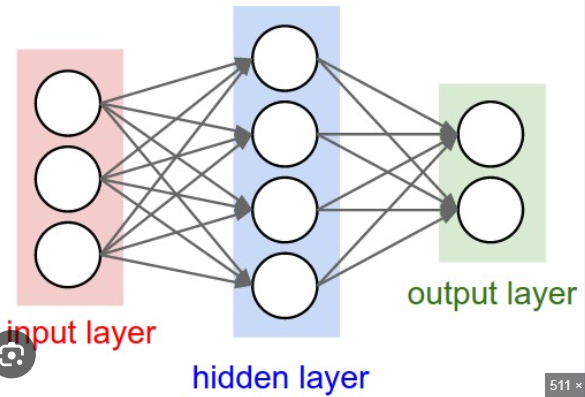

In [28]:
class LinearLayerManual:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        # Initialize weights and biases
        # Weights are typically initialized randomly
        self.weights = torch.randn(out_features, in_features)
        self.bias = torch.randn(out_features)

    def forward(self, x):
        # Perform the linear transformation: y = xW^T + b
        # torch.matmul performs matrix multiplication
        # x has shape (batch_size, in_features)
        # self.weights has shape (out_features, in_features)
        # x @ self.weights.T results in shape (batch_size, out_features)
        # Adding bias (broadcasting happens) results in shape (batch_size, out_features)
        return torch.matmul(x, self.weights.T) + self.bias

# Example usage:
# Create an instance of the manual linear layer
manual_layer = LinearLayerManual(in_features=10, out_features=5)

# Create a dummy input tensor (batch size of 1, 10 input features)
input_tensor = torch.randn(1, 10)

# Pass the input through the manual layer
output_tensor_manual = manual_layer.forward(input_tensor)

print("Manual Linear Layer Output:")
print(output_tensor_manual)

# Compare with PyTorch's nn.Linear
linear_layer_pytorch = nn.Linear(in_features=10, out_features=5)
# To get similar output values, we can copy the weights and biases
linear_layer_pytorch.weight = nn.Parameter(manual_layer.weights)
linear_layer_pytorch.bias = nn.Parameter(manual_layer.bias)


output_tensor_pytorch = linear_layer_pytorch(input_tensor)

print("\nPyTorch nn.Linear Output:")
print(output_tensor_pytorch)

# Check if the outputs are close
print("\nOutputs are close:", torch.allclose(output_tensor_manual, output_tensor_pytorch))

Manual Linear Layer Output:
tensor([[-0.9180,  4.8141, -2.2529, -2.2571, -0.8440]])

PyTorch nn.Linear Output:
tensor([[-0.9180,  4.8141, -2.2529, -2.2571, -0.8440]],
       grad_fn=<AddmmBackward0>)

Outputs are close: True


In [29]:
class Red_neuronal_1 (nn.Module):
  def __init__(self,
       capas_de_entrada, #input layer
       capas_ocultas, #hidden layer
       capas_de_salida): # output layer
    super(Red_neuronal_1, self).__init__()
    self.dense1 = nn.Linear(capas_de_entrada, capas_ocultas)
    self.hidden = nn.Linear(capas_ocultas, capas_ocultas)
    self.output = nn.Linear(capas_ocultas, capas_de_salida)
    self.softmax = nn.Softmax(1)
  def forward(self, x):
    dense_1_resultado = self.dense1(x)
    hidden_resultado = self.hidden(dense_1_resultado)
    output_resultado = self.output(hidden_resultado)
    softmax_resultado = self.softmax(output_resultado)
    return softmax_resultado

## Softmax

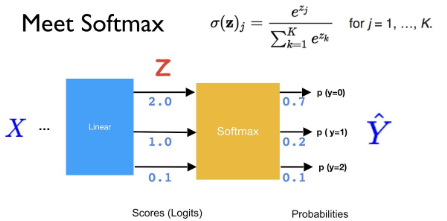

## Instanciación de clase

In [30]:
model = Red_neuronal_1(capas_de_entrada=3, capas_ocultas=4, capas_de_salida=2)
model.to(device)
model

Red_neuronal_1(
  (dense1): Linear(in_features=3, out_features=4, bias=True)
  (hidden): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

## Entendiendo el state dict

In [31]:
model.state_dict()

OrderedDict([('dense1.weight',
              tensor([[-0.0866, -0.2645,  0.4959],
                      [ 0.1287, -0.3194, -0.2922],
                      [-0.0276,  0.3224, -0.1475],
                      [-0.3294, -0.1977, -0.4313]], device='cuda:0')),
             ('dense1.bias',
              tensor([ 0.2059,  0.4469, -0.5435,  0.1341], device='cuda:0')),
             ('hidden.weight',
              tensor([[ 0.2583,  0.0907, -0.1781,  0.2610],
                      [ 0.2628,  0.1870, -0.0879, -0.1324],
                      [ 0.0535, -0.0883, -0.1490,  0.3196],
                      [ 0.4297, -0.0495, -0.1119,  0.0073]], device='cuda:0')),
             ('hidden.bias',
              tensor([-0.0299,  0.1202,  0.1401, -0.4541], device='cuda:0')),
             ('output.weight',
              tensor([[-0.1845,  0.4211,  0.1948, -0.0249],
                      [-0.3015, -0.3059, -0.4479, -0.1630]], device='cuda:0')),
             ('output.bias', tensor([0.1689, 0.3188], device='cuda:0'

In [32]:
torch.manual_seed(42)
random_tensor = torch.rand(3, 3)
random_tensor

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408]])

In [33]:
resultado = model(random_tensor.to(device))
resultado

tensor([[0.4981, 0.5019],
        [0.5287, 0.4713],
        [0.5271, 0.4729]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Función de pérdida, propagación hacia atrás y optimizadores



Optimizers:

SGD = small steps.

Adam = smarter, adaptive steps.

[Gradient Descend 3d](https://share.google/images/S1m70W8MtX2pOh1Uh)
[Gradient Descend 2d](https://share.google/images/JCFXt0cV3avwBKYCi)


In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

## Ahora si, hagamos chatGPT
Replicaremos el paper de 2017 que fue el que provocó la avalancha de la IA
https://arxiv.org/pdf/1706.03762

## La atención es todo lo que necesitas
Lo más importante que incluye este paper y esta nueva arquitectura es la atención

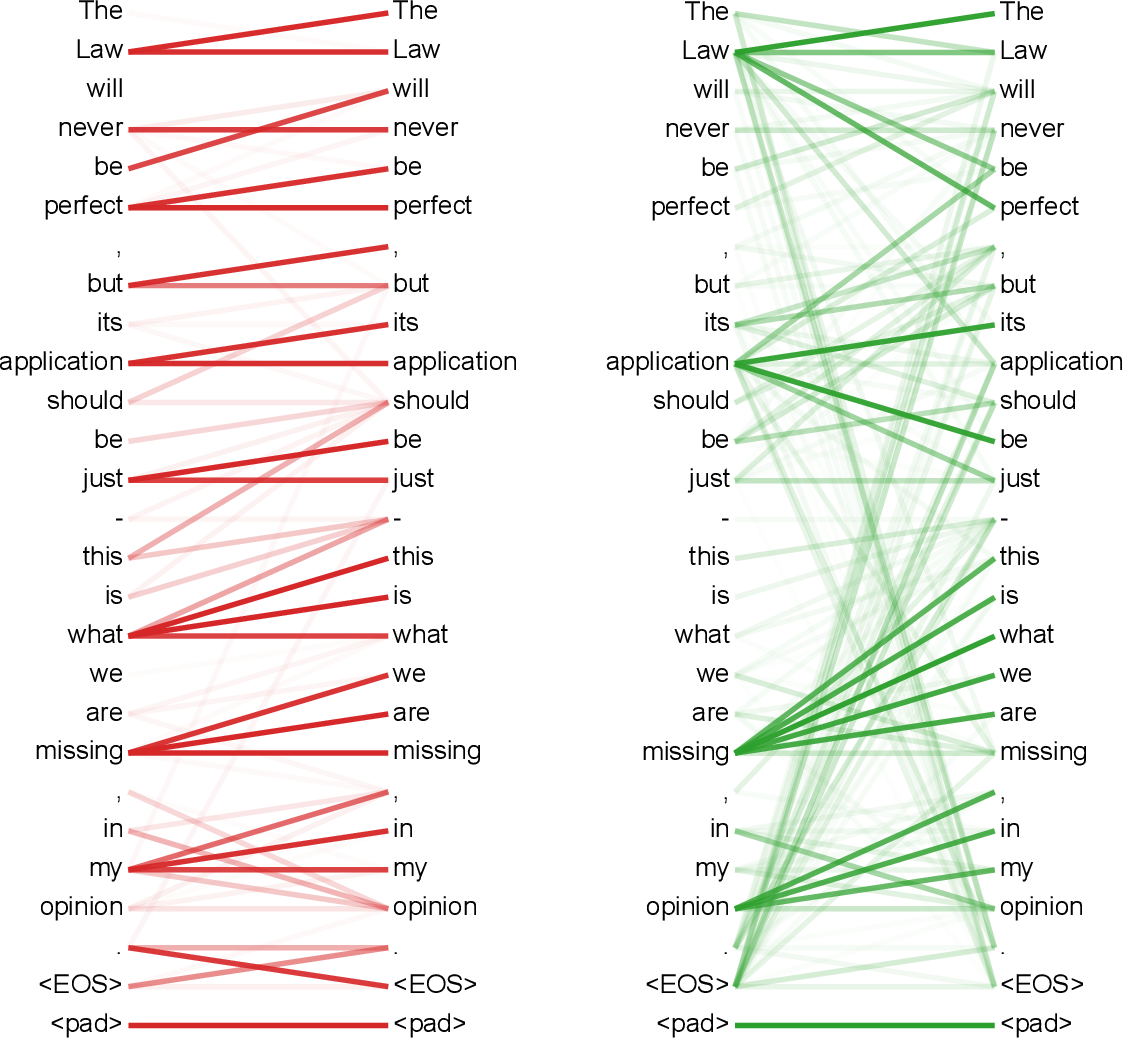

In [35]:
import math
# Example when d_model = 512 and num_heads = 8
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1] # 64
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3) # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200 in a probability distribution
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention


In [36]:
# Example when d_model = 512 and num_heads = 8
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads = num_heads # 8
        self.head_dim = d_model // num_heads # 64
        self.qkv_layer = nn.Linear(d_model , 3 * d_model) # 512 -> 1536
        self.linear_layer = nn.Linear(d_model, d_model) # 512 -> 512

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        qkv = self.qkv_layer(x) # 30 x 200 x 1536
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x 192
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 192
        q, k, v = qkv.chunk(3, dim=-1) # q,k, v = 30 x 8 x 200 x 64
        values, attention = scaled_dot_product(q, k, v, mask) # 30 x 8 x 200 x 64, 30 x 8 x 200 x 200
        values = values.permute(0, 2, 1, 3) # 30 x 200 x 8 x 64
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x 512
        out = self.linear_layer(values) # 30 x 200 x 512
        return out

In [37]:
# Example when d_model = 512 and num_heads = 8
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads = num_heads # 8
        self.head_dim = d_model // num_heads # 64
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 512 -> 1024
        self.q_layer = nn.Linear(d_model , d_model) # 512 -> 512
        self.linear_layer = nn.Linear(d_model, d_model) # 512 -> 512

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x) # 30 x 200 x 1024
        q = self.q_layer(y) # 30 x 8 x 200 x 512
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim) # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) # 30 x 200 x 8 x 64
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        k, v = kv.chunk(2, dim=-1) # k, v = 30 x 8 x 200 x 64
        # dot product attentopn requires q, k, v to be of shape (batch_size, num_heads, sequence_length, head_dim)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3) # 30 x 200 x 8 x 64
        values = values.reshape(batch_size, sequence_length, d_model) # 30 x 200 x 512
        out = self.linear_layer(values) # 30 x 200 x 512
        return out

In [38]:
class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index) # Number of unique words (or tokens) in the language
        self.max_sequence_length = max_sequence_length # Maximum length of a sentence
        self.embedding = nn.Embedding(self.vocab_size, d_model) # Embedding using already trained word embeddings
        self.language_to_index = language_to_index # Dictionary mapping words to unique indices
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length) # Positional Encoding
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start_token:
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies) # returns a tensor with all words converted into the dictionary index with padding and tokens

        tokenized = []
        for sentence_num in range(len(batch)): # for each batch of sentences tokenizr
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device()) # send the tensor to the device

    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token) # tokenize all batches
        x = self.embedding(x) # create the vector
        pos = self.position_encoder().to(get_device()) # positional encoding to the device
        x = self.dropout(x + pos)
        return x

In [39]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # get the dimensions of the input
        mean = inputs.mean(dim=dims, keepdim=True) # mean maintining dimensions 30 x 200 x 1
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # variance
        std = (var + self.eps).sqrt() # standard deviation
        y = (inputs - mean) / std # normalization 30 x 200 x 512
        out = self.gamma * y + self.beta # trainable parameters
        return out

In [40]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float() # formula in the paper
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2) # stack (left, right left...)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2) # flatten the tensor
        return PE # Create a positional encoding vector of dimensions max_sequence_length x d_mode

In [41]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x) # 512 -> 2048
        x = self.relu(x) # activation
        x = self.dropout(x)
        x = self.linear2(x) # 2048 -> 512
        return x

In [42]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads = num_heads # 8
        self.head_dim = d_model // num_heads # 64
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 512 -> 1024
        self.q_layer = nn.Linear(d_model , d_model) # 512 -> 512
        self.linear_layer = nn.Linear(d_model, d_model) # 512 -> 512

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x) # 30 x 200 x 1024
        q = self.q_layer(y) # 30 x 8 x 200 x 512
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim) # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) # 30 x 200 x 8 x 64
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        k, v = kv.chunk(2, dim=-1) # k, v = 30 x 8 x 200 x 64
        # dot product attentopn requires q, k, v to be of shape (batch_size, num_heads, sequence_length, head_dim)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3) # 30 x 200 x 8 x 64
        values = values.reshape(batch_size, sequence_length, d_model) # 30 x 200 x 512
        out = self.linear_layer(values) # 30 x 200 x 512
        return out

In [43]:
class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token) # Encoding
        y = self.layers(x, y, self_attention_mask, cross_attention_mask) # Steps in the transformer decoder
        return y


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads) # masked multi-head attention
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model]) # layer normalization
        self.dropout1 = nn.Dropout(p=drop_prob) # dropout

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone() # residual connection
        y = self.self_attention(y, mask=self_attention_mask) # masked multi-head attention
        y = self.dropout1(y) # dropout
        y = self.layer_norm1(y + _y) # add with residual conection # 30 x 200 x 512

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask) # cross attention
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y) # feed forward 512 -> 2048 -> 512
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs): # we do this to repeat the decoder process
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

In [44]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone() # 30 x 200 x 512
        x = self.attention(x, mask=self_attention_mask) # 30 x 200 x 512 multi head attention
        x = self.dropout1(x)
        x = self.norm1(x + residual_x) # normalization
        residual_x = x.clone()
        x = self.ffn(x) # 512 -> 2048 -> 512
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs): # do the encoder step n times
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token) # embedding
        x = self.layers(x, self_attention_mask) # encoder layers
        return x

In [45]:
class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                kn_vocab_size,
                english_to_index,
                kannada_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, kannada_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, kn_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out) # batch_size x max_sequence_length x d_model -> batch_size x max_sequence_length x vocab_size
        return out

In [47]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
from tqdm import tqdm
import json
from functools import reduce
from torch.utils.data import Dataset, DataLoader
# english_file = 'NN/firstTransformer/data/english.txt'
# spanish_file = 'NN/firstTransformer/data/spanish.txt'

# Load English & Spanish NLP Models
# nlp_eng = spacy.load("en_core_web_sm", disable=["ner", "parser"])
# nlp_spa = spacy.load("es_core_news_sm", disable=["ner", "parser"])
import tiktoken

# Use tiktoken from openai
# -------------------------------------------------------------------------Models for word tokens
nlp_spa = spacy.blank('es')
nlp_eng = spacy.blank('en')
nlp = [nlp_eng, nlp_spa]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


languages = ['english', 'spanish'] # Languages for which the model will be available to switch ()
languages_dict = {}

for language in languages:
   path = f'NN/firstTransformer/data/{language}.txt'
   with open(path, 'r') as file:
      languages_dict[language] = file.read().split('\n')


languages_df = pd.DataFrame(languages_dict)

START_TOKEN = '<START>'
PADDING_TOKEN = '<PAD>'
END_TOKEN = '<END>'
TOKENS_LIST = [START_TOKEN, END_TOKEN, PADDING_TOKEN]
TOTAL_SENTENCES = languages_df.shape[0]

PERCENTILE = 95

# Prints the number of word count of the percentile 95
for language in languages:
    print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in languages_df[language].values], PERCENTILE)}" )



VOCAB_SIZE = 10000
# Show the most common words in the English language

VOCAB = {}


def tokenize(texts_df, nlp_model):
    list_of_tokens = defaultdict(int)  # Initialize with 0 for each key

    # Iterate through each document
    for doc in tqdm(nlp_model.pipe(texts_df, batch_size=10000, disable=["ner", "parser"])):
        for token in doc:
            # Skip punctuation and spaces
            if token.is_punct or token.is_space:
                continue

            # Count the tokenized word itself
            list_of_tokens[token.text.lower()] = []
            list_of_tokens[token.text.lower()].append(token.text.lower())

            # Count the lemma (root form of the word)
            if token.lemma_ != "-PRON-":  # Avoid lemmatized pronouns (which might be "-PRON-")
                list_of_tokens[token.text.lower()].append(token.lemma_.lower())

            # Count the prefix (first 3 characters) and suffix (last 3 characters)
            try:


                if len(token.text) > 3 and token.text not in TOKENS_LIST:  # Avoid short words
                    # Prefix
                    list_of_tokens[token.text.lower()].append(token.text.lower()[:3] + "-")

                    # Suffix
                    list_of_tokens[token.text.lower()].append("-" + token.text.lower()[-3:])
            except:
                continue

    return list_of_tokens

# Process English and Spanish separately
with open('NN/firstTransformer/data/vocab.json', 'r') as file:
    VOCAB = json.load(file)

if len(VOCAB.keys()) == 0:
    for i, language in enumerate(languages):

        VOCAB[language] = tokenize(languages_df[language], nlp[i])
        VOCAB[language]['tokens'] = [START_TOKEN, END_TOKEN, PADDING_TOKEN]

# Save the vocabulary to a JSON file
with open('NN/firstTransformer/data/vocab.json', 'w') as file:
    json.dump(VOCAB, file, ensure_ascii=False, indent=4)


vocab_set = set()
for element in VOCAB['spanish']:
    vocab_set.add(element)

# Maps a word to a specific index
index_to_language = {}
language_to_index = {}
for language in languages:
    index_to_language[language] = {k:v for k, v in enumerate(VOCAB[language])}
    language_to_index[language] = {v:k for k, v in enumerate(VOCAB[language])}



# LIMIT NUMBER OF SENTENCES
MAX_SEQUENCE_LENGTH = 350

# Working for single words
def is_valid_tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

#print(is_valid_tokens('Hola soy manuel', VOCAB['spanish']))
#print(list(set('Hola soy manuel')))
def length_is_valid(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1) # need to re-add the end token so leaving 1 space

# For various languagesç
valid_sentence_indices = []
for index in range(len(languages_df)):
    valid = True
    for language in languages:
        sentence = languages_df[language].values[index].lower().split()
        if not length_is_valid(sentence, MAX_SEQUENCE_LENGTH): #or not is_valid_tokens(sentence, VOCAB[language]):
            valid = False
            break
    if valid:
        valid_sentence_indices.append(index)

valid_sentences = {}
for language in languages:
    valid_sentences[language] = [languages_df[language].values[i].lower() for i in valid_sentence_indices]



# TRANSFORMER MODEL

d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 200

sp_vocab_size = len(vocab_set)

transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          sp_vocab_size,
                          language_to_index['english'],
                          language_to_index['spanish'],
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN).to(device)

class TextDataset(Dataset):

    def __init__(self, english_sentences, kannada_sentences):
        self.english_sentences = english_sentences
        self.kannada_sentences = kannada_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.kannada_sentences[idx]


dataset = TextDataset(valid_sentences['english'], valid_sentences['spanish'])

train_loader = DataLoader(dataset, batch_size)


loss_fn = nn.CrossEntropyLoss(#ignore_index=language_to_index['spanish'][PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)

NEG_INFTY = -1e9

def create_masks(eng_batch, kn_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, kn_sentence_length = len(eng_batch[idx]), len(kn_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      kn_chars_to_padding_mask = np.arange(kn_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, kn_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, kn_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, kn_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask


total_loss = 0
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")

    for batch, (X, Y) in enumerate(train_loader):
        print(X[0], Y[0])
        break
        transformer.train()
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(X, Y)
        optim.zero_grad()
        kn_predictions = transformer(eng_batch,
                                     kn_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(kn_batch, start_token=False, end_token=True)
        loss = loss_fn(
            kn_predictions.view(-1, sp_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == language_to_index['spanish'][PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Kannada Translation: {kn_batch[0]}")
            kn_sentence_predicted = torch.argmax(kn_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in kn_sentence_predicted:
              if idx == language_to_index['spanish'][END_TOKEN]:
                break
              predicted_sentence += language_to_index['spanish'][idx.item()]
            print(f"Kannada Prediction: {predicted_sentence}")


            transformer.eval()
            kn_sentence = ("",)
            eng_sentence = ("should we go to the mall?",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, kn_sentence)
                predictions = transformer(eng_sentence,
                                          kn_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_language['spanish'][next_token_index]
                kn_sentence = (kn_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation translation (should we go to the mall?) : {kn_sentence}")
            print("-------------------------------------------")


transformer.eval()
def translate(eng_sentence):
  eng_sentence = (eng_sentence,)
  kn_sentence = ("",)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, kn_sentence)
    predictions = transformer(eng_sentence,
                              kn_sentence,
                              encoder_self_attention_mask.to(device),
                              decoder_self_attention_mask.to(device),
                              decoder_cross_attention_mask.to(device),
                              enc_start_token=False,
                              enc_end_token=False,
                              dec_start_token=True,
                              dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter]
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = index_to_language['spanish'][next_token_index]
    kn_sentence = (kn_sentence[0] + next_token, )
    if next_token == END_TOKEN:
      break
  return kn_sentence[0]

translation = translate("what should we do when the day starts?")
print(translation)

FileNotFoundError: [Errno 2] No such file or directory: 'NN/firstTransformer/data/english.txt'